---
title: "Modeling - Playground Series Season 3, Episode 4"
description: "Tabular Classification with a Credit Card Fraud Dataset"
author: "Sagar Thacker"
date: "2023-01-30"
categories: [Kaggle]
image: "money.jpeg"
format:
    html:
        toc: true
        code-overflow: wrap
        code-line-numbers: true
jupyter: python3
---


To read more about Exploratory Data Analysis for this problem statement, you can read my notebook [here](./pss3e4-eda.html)

It was my first try at a kaggle comptetion and I got a lot to learn. This notebook helped me get a score of:

-   Public Score: 0.85646
-   Private score: 0.81208

Position: 138/641


In [1]:
# | code-fold: true
# Import libraries

import numpy as np
import pandas as pd
import catboost
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from collections import defaultdict
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from boruta import BorutaPy

pd.options.display.max_columns = None
%matplotlib inline


## 1. Data Description

The dataset for this competition (both train and test) was generated from a deep learning model trained on the [Credit Card Fraud Detection](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud). Feature distributions are close to, but not exactly the same, as the original.

We are given three files:

-   train.csv - the training dataset; Class is the target
-   test.csv - the test dataset; our objective is to predict Class
-   sample_submission.csv - a sample submission file in the correct format

Description of each column:

| Feature | Description                                                                                 |
| :------ | :------------------------------------------------------------------------------------------ |
| id      | Indentifier for unique rows                                                                 |
| Time    | Number of seconds elapsed between this transaction and the first transaction in the dataset |
| V1-V28  | Features generated from the original dataset                                                |
| Amount  | Transaction amount                                                                          |
| Class   | Target Feature: 1 for fraudulent transactions, 0 otherwise                                  |

: Feature Description {tbl-colwidths="[10,75]"}


## 2. Data Preparation


In [2]:
__dirname = '../input/playground-series-s3e4/'
og_data = '/kaggle/input/creditcardfraud/creditcard.csv'

train = pd.read_csv(__dirname + 'train.csv')
test = pd.read_csv(__dirname + 'test.csv')
original = pd.read_csv(og_data)
submissions = pd.read_csv(__dirname + 'sample_submission.csv')


In [3]:
print(f"Training set has {train.shape[0]} rows and {train.shape[1]} columns")
print(f"Testing set has {test.shape[0]} rows and {test.shape[1]} columns")
print(
    f"Original set has {original.shape[0]} rows and {original.shape[1]} columns")


Training set has 219129 rows and 32 columns
Testing set has 146087 rows and 31 columns
Original set has 284807 rows and 31 columns


In [4]:
# Check for missing values
print(f"Number of missing values in training set: {sum(train.isna().sum())}")
print(f"Number of missing values in testing set: {sum(test.isna().sum())}")
print(
    f"Number of missing values in original set: {sum(original.isna().sum())}")


Number of missing values in training set: 0
Number of missing values in testing set: 0
Number of missing values in original set: 0


In [5]:
# Merge train and original
train = pd.concat([train, original], axis=0, ignore_index=True)


In [6]:
cols = [col for col in train.columns if col not in ['id', 'Time']]
print(' Number of duplicates with new criteria:',
      train[cols].duplicated().sum())


 Number of duplicates with new criteria: 9254


In [7]:
# Drop Duplicates
train.drop_duplicates(subset=cols, inplace=True, keep='first')


In [8]:
# Drop columns
train.drop(['id', 'Time'], axis=1, inplace=True)
test.drop(['id', 'Time'], axis=1, inplace=True)


## 3. Modeling


In [9]:
# Perform feature scaling
scaler = RobustScaler()

cols = test.columns
train[cols] = scaler.fit_transform(train[cols])
test[cols] = scaler.transform(test[cols])


In [10]:
X_train, y_train = train.drop('Class', axis=1), train.Class


In [11]:
# Dictionary to save model results
results = defaultdict(lambda: defaultdict(list))


In [12]:
# Function to plot feature importance
def plot_feature_imp(df, col):
    df = pd.concat(df, axis=1).head(15)
    df.sort_values(col).plot(kind='barh', figsize=(
        15, 10), title="Feature Imp Across Folds")
    plt.show()


### 3.1. Baseline Model


In [13]:
n_folds = 5
seed = 42
model = 'Logistic Regression'

skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)
test_pred = 0

results[model] = defaultdict(list)

for idx, (train_idx, test_idx) in enumerate(skf.split(X_train, y_train)):
    X, y = X_train.iloc[train_idx], y_train.iloc[train_idx]
    X_valid, y_valid = X_train.iloc[test_idx], y_train.iloc[test_idx]

    lr = LogisticRegression()

    # Fit the model
    lr.fit(X, y)
    # Predict on validation set
    pred_proba = lr.predict_proba(X_valid)[:, 1]

    # Predict on test set
    test_pred_proba = lr.predict_proba(test)[:, 1]
    test_pred += test_pred_proba/n_folds

    # Calcualte AUC score
    auc = roc_auc_score(y_valid, pred_proba)

    # Feature Importance
    feature_imp = pd.DataFrame(index=X_train.columns,
                               data=lr.coef_[0],
                               columns=[f"{idx + 1}_importance"])

    print(f"Fold={idx+1}, AUC score: {auc:.2f}")

    # Save Results
    results[model]['auc'].append(auc)
    results[model]['model'].append(lr)
    results[model]['feature_imp'].append(feature_imp)

results[model]['test_pred'] = test_pred
print(f"Mean AUC: {np.mean(results[model]['auc'])}")


Fold=1, AUC score: 0.85
Fold=2, AUC score: 0.88
Fold=3, AUC score: 0.88
Fold=4, AUC score: 0.87
Fold=5, AUC score: 0.86
Mean AUC: 0.8679439362536849


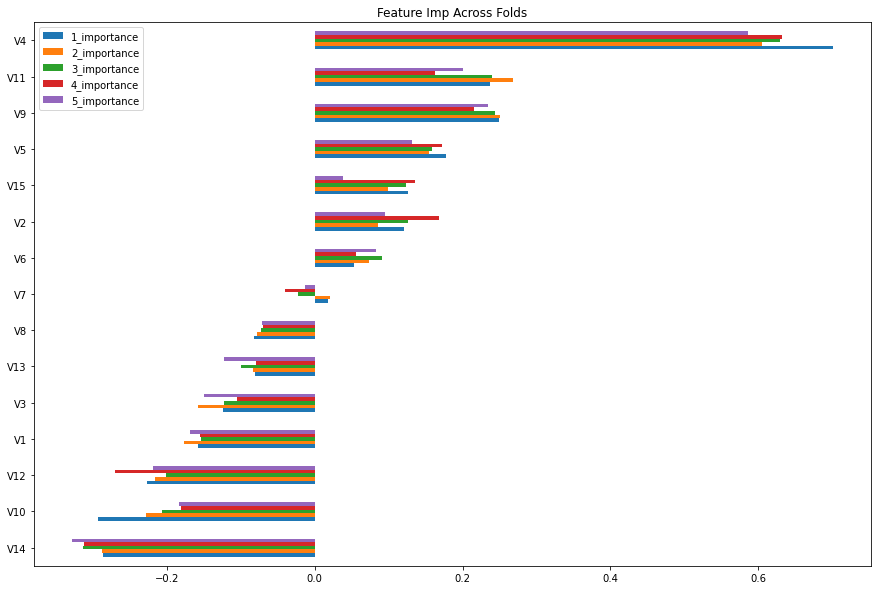

In [14]:
# Plot feature importance for logistic regression model
plot_feature_imp(results[model]['feature_imp'], "2_importance")


In [15]:
# Made a baseline submission to see how the model performs
lr_submission = submissions.copy()
lr_submission['Class'] = results[model]['test_pred']
lr_submission.to_csv('lr_submission.csv', index=False)


In [16]:
lr_submission.head()


,id,Class
0,219129,0.001192
1,219130,0.000621
2,219131,0.000201
3,219132,0.000699
4,219133,0.000361


### 3.2. XGBoost Classifier


In [17]:
xgb_params = {
    'n_estimators': 2000,
    'min_child_weight': 96,
    'max_depth': 7,
    'learning_rate': 0.18,
    'subsample': 0.95,
    'colsample_bytree': 0.95,
    'reg_lambda': 1.50,
    'reg_alpha': 1.50,
    'gamma': 1.50,
    'max_bin': 512,
    'random_state': seed,
    'objective': 'binary:logistic',
    'tree_method': 'hist',
    'eval_metric': 'auc'
}


In [18]:
n_folds = 5
seed = 42
model = 'XGBoostClassifier'

skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)
test_pred = 0

results[model] = defaultdict(list)

for idx, (train_idx, test_idx) in enumerate(skf.split(X_train, y_train)):
    X, y = X_train.iloc[train_idx], y_train.iloc[train_idx]
    X_valid, y_valid = X_train.iloc[test_idx], y_train.iloc[test_idx]

    xgb = XGBClassifier(**xgb_params)

    # Fit the model
    xgb.fit(X, y)
    # Predict on validation set
    pred_proba = xgb.predict_proba(X_valid)[:, 1]

    # Predict on test set
    test_pred_proba = xgb.predict_proba(test)[:, 1]
    test_pred += test_pred_proba/n_folds

    # Calcualte AUC score
    auc = roc_auc_score(y_valid, pred_proba)

    # Feature Importance
    feature_imp = pd.DataFrame(index=X_train.columns,
                               data=xgb.feature_importances_,
                               columns=[f"{idx + 1}_importance"])

    print(f"Fold={idx+1}, AUC score: {auc:.2f}")

    # Save Results
    results[model]['auc'].append(auc)
    results[model]['model'].append(lr)
    results[model]['feature_imp'].append(feature_imp)

results[model]['test_pred'] = test_pred
print(f"Mean AUC: {np.mean(results[model]['auc'])}")


Fold=1, AUC score: 0.88
Fold=2, AUC score: 0.90
Fold=3, AUC score: 0.91
Fold=4, AUC score: 0.89
Fold=5, AUC score: 0.90
Mean AUC: 0.8951748159271997


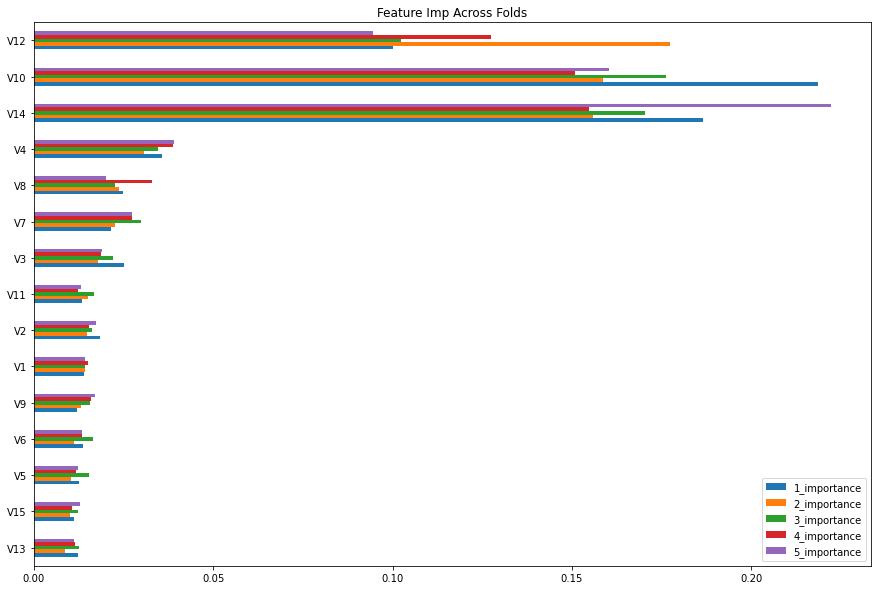

In [19]:
# Plot feature importance for XGBoost model
plot_feature_imp(results[model]['feature_imp'], "2_importance")


In [20]:
# Made a submission to see how the model performs
xgb_submission = submissions.copy()
xgb_submission['Class'] = results[model]['test_pred']
xgb_submission.to_csv('xgb_submission.csv', index=False)


In [21]:
xgb_submission.head()


,id,Class
0,219129,0.001166
1,219130,0.000573
2,219131,0.000367
3,219132,0.001084
4,219133,0.000131


### 3.3. LightGBM Classifier


In [22]:
lgbm_params = {
    'n_estimators': 500,
    'learning_rate': 0.1,
    'num_leaves': 195,
    'max_depth': 9,
    'min_data_in_leaf': 46,
    'lambda_l1': 0.01,
    'lambda_l2': 0.6,
    'min_gain_to_split': 1.42,
    'bagging_fraction': 0.45,
    'feature_fraction': 0.3,
    'verbosity': -1,
    'boosting_type': 'dart',
    'random_state': seed,
    'objective': 'binary'
}


In [23]:
n_folds = 5
seed = 42
model = 'LGBMClassifier'

skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)
test_pred = 0

results[model] = defaultdict(list)

for idx, (train_idx, test_idx) in enumerate(skf.split(X_train, y_train)):
    X, y = X_train.iloc[train_idx], y_train.iloc[train_idx]
    X_valid, y_valid = X_train.iloc[test_idx], y_train.iloc[test_idx]

    lgbm = LGBMClassifier(**lgbm_params)

    # Fit the model
    lgbm.fit(X, y)
    # Predict on validation set
    pred_proba = lgbm.predict_proba(X_valid)[:, 1]

    # Predict on test set
    test_pred_proba = lgbm.predict_proba(test)[:, 1]
    test_pred += test_pred_proba/n_folds

    # Calcualte AUC score
    auc = roc_auc_score(y_valid, pred_proba)

    # Feature Importance
    feature_imp = pd.DataFrame(index=X_train.columns,
                               data=lgbm.feature_importances_,
                               columns=[f"{idx + 1}_importance"])

    print(f"Fold={idx+1}, AUC score: {auc:.2f}")

    # Save Results
    results[model]['auc'].append(auc)
    results[model]['model'].append(lr)
    results[model]['feature_imp'].append(feature_imp)

results[model]['test_pred'] = test_pred
print(f"Mean AUC: {np.mean(results[model]['auc'])}")


[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] bagging_fraction is set=0.45, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] min_gain_to_split is set=1.42, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.42
[LightGBM] [Warning] lambda_l2 is set=0.6, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6
Fold=1, AUC score: 0.89
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] bagging_fraction is set=0.45, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45
[LightGBM] [Warning] min_data_in_leaf is set=46, min

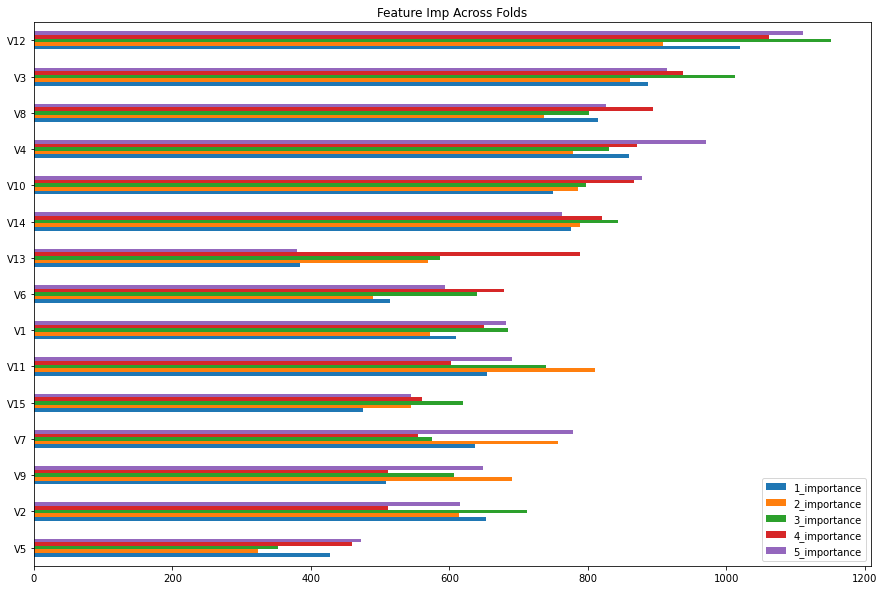

In [24]:
# Plot feature importance for LightGBM model
plot_feature_imp(results[model]['feature_imp'], "4_importance")


In [25]:
# Made a submission to see how the model performs
lgbm_submission = submissions.copy()
lgbm_submission['Class'] = results[model]['test_pred']
lgbm_submission.to_csv('lgbm_submission.csv', index=False)


In [26]:
lgbm_submission.head()


,id,Class
0,219129,0.001045
1,219130,0.000622
2,219131,0.000337
3,219132,0.000817
4,219133,0.000307


### 3.4. CatBoot Classifier


In [27]:
catboost_params = {
    'n_estimators': 500,
    'learning_rate': 0.1,
    'one_hot_max_size': 12,
    'depth': 9,
    'l2_leaf_reg': 0.6,
    'colsample_bylevel': 0.06,
    'min_data_in_leaf': 12,
    'bootstrap_type': 'Bernoulli',
    'verbose': False,
    'random_state': seed,
    'objective': 'Logloss',
    'eval_metric': 'AUC'
}


In [28]:
n_folds = 5
seed = 42
model = 'CatBoostClassifier'

skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)
test_pred = 0

results[model] = defaultdict(list)

for idx, (train_idx, test_idx) in enumerate(skf.split(X_train, y_train)):
    X, y = X_train.iloc[train_idx], y_train.iloc[train_idx]
    X_valid, y_valid = X_train.iloc[test_idx], y_train.iloc[test_idx]

    catb = CatBoostClassifier(**catboost_params)

    # Fit the model
    catb.fit(X, y)
    # Predict on validation set
    pred_proba = catb.predict_proba(X_valid)[:, 1]

    # Predict on test set
    test_pred_proba = catb.predict_proba(test)[:, 1]
    test_pred += test_pred_proba/n_folds

    # Calcualte AUC score
    auc = roc_auc_score(y_valid, pred_proba)

    # Feature Importance
    feature_imp = pd.DataFrame(index=X_train.columns,
                               data=catb.feature_importances_,
                               columns=[f"{idx + 1}_importance"])

    print(f"Fold={idx+1}, AUC score: {auc:.2f}")

    # Save Results
    results[model]['auc'].append(auc)
    results[model]['model'].append(lr)
    results[model]['feature_imp'].append(feature_imp)

results[model]['test_pred'] = test_pred
print(f"Mean AUC: {np.mean(results[model]['auc'])}")


Fold=1, AUC score: 0.87
Fold=2, AUC score: 0.88
Fold=3, AUC score: 0.88
Fold=4, AUC score: 0.89
Fold=5, AUC score: 0.89
Mean AUC: 0.877921430469104


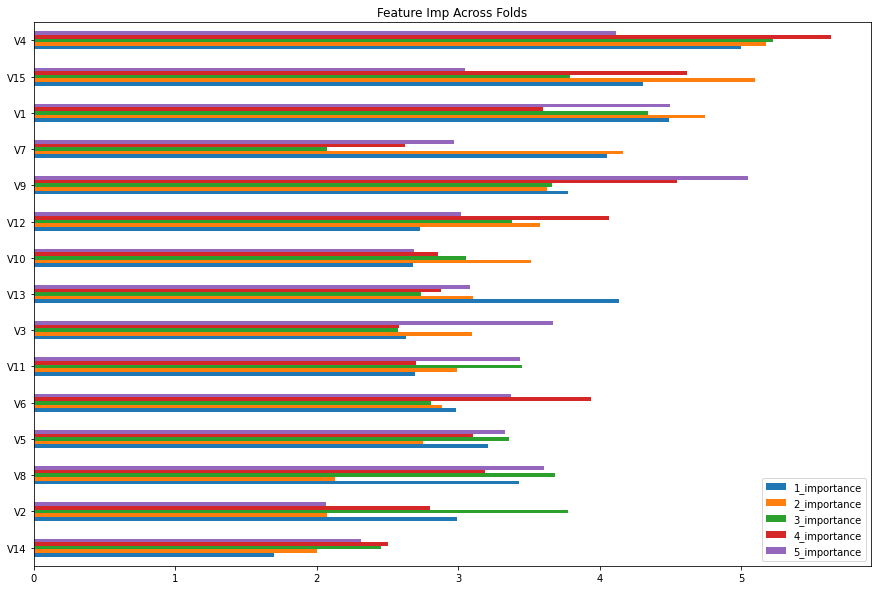

In [29]:
# Plot feature importance for CatBoost model
plot_feature_imp(results[model]['feature_imp'], "2_importance")


In [30]:
# Made a submission to see how the model performs
catb_submission = submissions.copy()
catb_submission['Class'] = results[model]['test_pred']
catb_submission.to_csv('catb_submission.csv', index=False)


In [31]:
catb_submission.head()


,id,Class
0,219129,0.000671
1,219130,0.000433
2,219131,0.000124
3,219132,0.000599
4,219133,0.000103


### 3.5. Ensemble Results


In [32]:
a = 0.1
b = 0.4
c = 0.3
d = 0.2

pred = a * lr_submission['Class'] + b * xgb_submission['Class'] + \
    c * lgbm_submission['Class'] + d * catb_submission['Class']

# Made a submission to see how the model performs
submission = submissions.copy()
submission['Class'] = pred
submission.to_csv('submission_CatB.csv', index=False)


In [33]:
a = 0
b = 0.4
c = 0.4
d = 0.2

pred = a * lr_submission['Class'] + b * xgb_submission['Class'] + \
    c * lgbm_submission['Class'] + d * catb_submission['Class']

# Made a submission to see how the model performs
submission = submissions.copy()
submission['Class'] = pred
submission.to_csv('submission_noLR.csv', index=False)


## 4. Conclusion

Thank you for reading so far and I hope you found this notebook helpful.

Upvote if you liked it, comment if you loved it. Hope to see you guys in the next one. Peace!
